In [167]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh
import pandas as pd

# IMPORTANDO DADOS

In [168]:
path = 'DataBase.csv'
df   = pd.read_csv(path)
df.head()

,time,pressure
0,0.001,104.0989
1,0.001,104.1020
2,0.076,104.1208
3,0.174,104.0262
4,0.271,103.7383


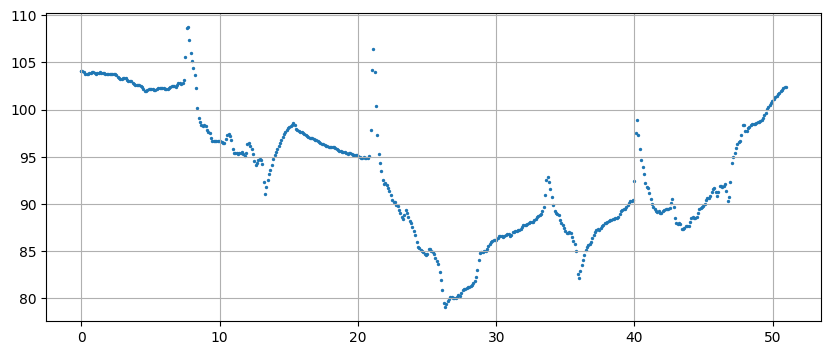

In [169]:
plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, s=2)
plt.grid()

# NORMALIZANDO DADOS

In [170]:
T = 0.100

In [171]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
df

,time,pressure
0,0.0,104.1020
1,0.1,104.1208
2,0.2,104.0262
3,0.3,103.7383
4,0.4,103.7310
...,...,...
506,50.6,101.9346
507,50.7,102.0608
508,50.8,102.3115
509,50.9,102.4059


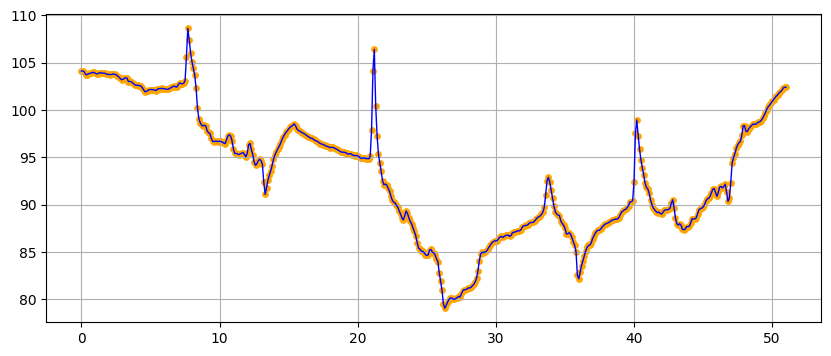

In [172]:
xData, yData = df.time.values, df.pressure.values

plt.figure(figsize=(10, 4))
plt.scatter(xData, yData, s=15, color='orange')
plt.plot(xData, yData, linewidth=1, color='blue')
plt.grid()

# ANÁLISE EM FREQUÊNCIA

**DOMÍNIO DA FREQUÊNCIA** $\Rightarrow$ Fazendo a transformada de Fourier para obter os dados no domínio da frequência, onde o eixo horizontal indica a frequência e o eixo vertical indica a amplitude, geralmente as amplitudes maiores são os alvos desejados, perto de frequências baixas

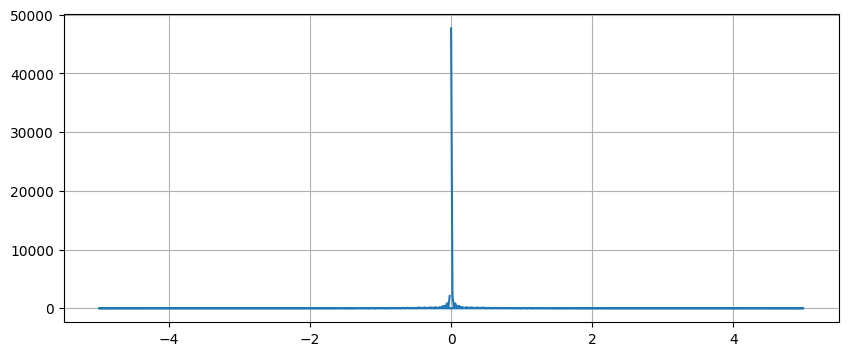

In [173]:
magnitude = np.fft.fft(yData)
frequency = np.fft.fftfreq(len(yData), T)

plt.figure(figsize=(10, 4))
plt.plot(frequency, np.abs(magnitude))
#plt.xlim(-0.5, 0.5)
plt.grid()

**FILTRO PASSA BAIXA** $\Rightarrow$ O gráfico acima apresenta ruído depois da frequência principal do sistema, o objetivo é eliminar o ruído e impedir com que essas frequências sejam interpretadas

- Isso é feito escolhendo uma frequência de corte, em que tudo que está acima dessa frequência é bloqueado

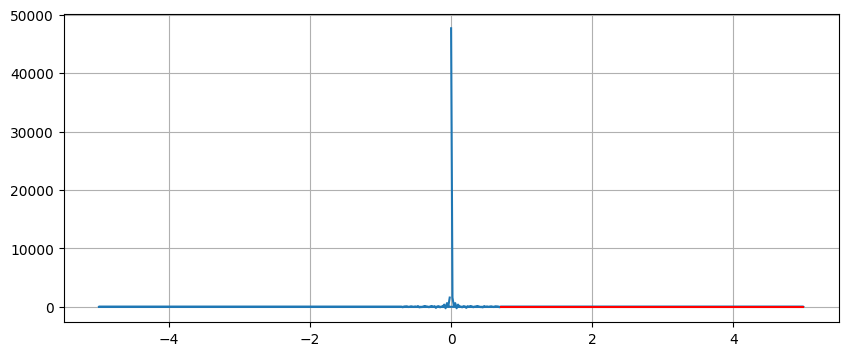

In [174]:
f_c = 0.70

def lowPass(frequencyArray, magnitudeArray, upperLimit):
    allowed = np.abs(frequencyArray) <= upperLimit
    magnitudeArray[~allowed] = 0
    return magnitudeArray


magnitude  = lowPass(frequency, magnitude, f_c)
eliminated = (frequency > f_c)

plt.figure(figsize=(10, 4))
plt.plot(frequency, magnitude.real)
plt.plot(frequency[eliminated], magnitude.real[eliminated], color='red')
plt.grid()

- Voltando para o domínio do tempo com o filtro perfeito

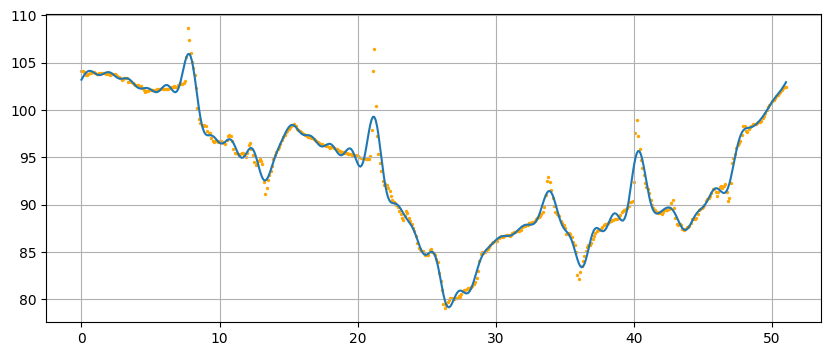

In [175]:
yData = np.fft.ifft(magnitude).real

plt.figure(figsize=(10, 4))
plt.plot(xData, yData)
plt.scatter(df.time, df.pressure, s=2, color='orange')
plt.grid()

# FILTRO DE FREQUÊNCIA
- A função de transferência do filtro de primeira ordem tem cara: 

- $C(s) = \frac{1}{Ks + 1}$, $\,\,\,\,\,\,\,\,$ onde $K = \frac{1}{w_c}$

In [176]:
w_c = 2*np.pi*f_c
f_c, w_c

(0.7, 4.39822971502571)

In [177]:
K = 1/w_c
K

0.22736420441699334

In [178]:
s = ctl.TransferFunction.s

C = 1/(K*s + 1)
C

TransferFunction(array([1]), array([0.2273642, 1.       ]))

**COMPARAÇÃO COM O FILTRO PADRÃO** $\Rightarrow$ Vamos comparar o filtro perfeito, construído em numpy, com o filtro feito pela função de transferência, os dois devem ser aproximadamente iguais

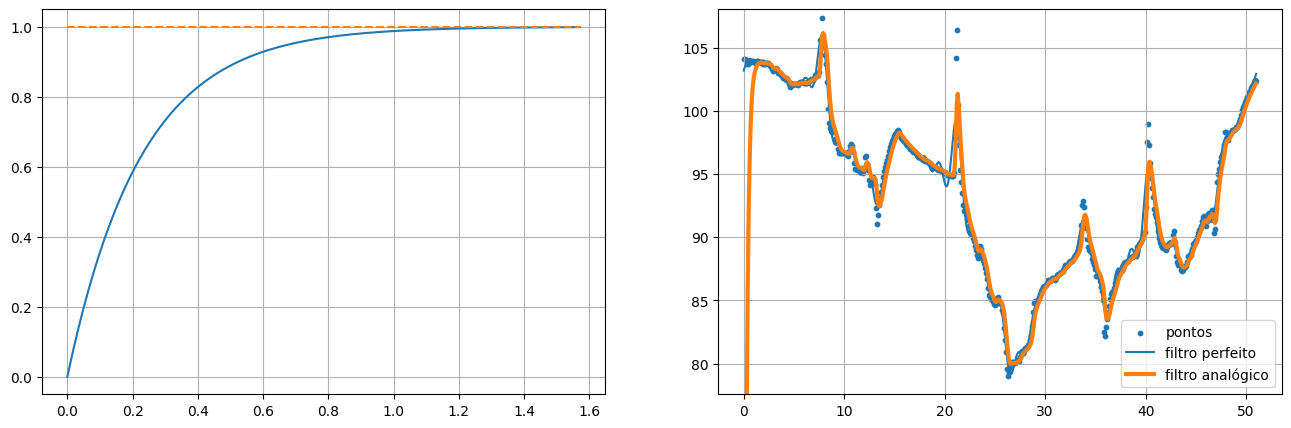

In [179]:
time, response = ctl.step_response(C)
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

xTest, yTest  = df.time.values, df.pressure.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)

plt.subplot(1, 2, 2)
plt.scatter(df.time, df.pressure, s=10, label='pontos')
plt.plot(xData, yData, label='filtro perfeito')
plt.plot(time, reponse, label='filtro analógico', linewidth=3)

plt.ylim(min(yData)*0.98, max(yData)*1.02)
plt.legend()
plt.grid()

**TESTE GRÁFICO** $\Rightarrow$ O gráfico abaixo mostra que quando a frequência se aproxima da frequência $\omega_{desired}$, ocorre a atenuação

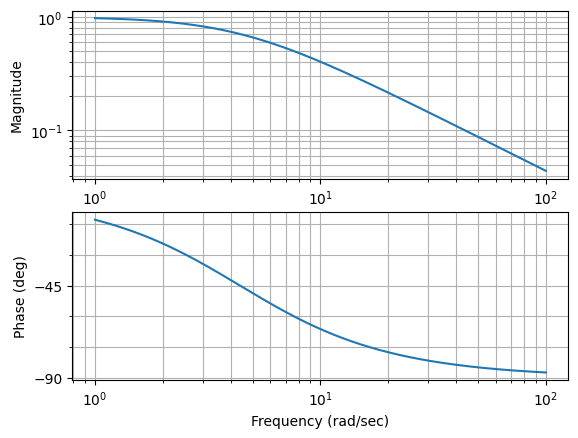

In [180]:
mag, fase, omega = ctl.bode(C, plot=True)

**TESTE NUMÉRICO** $\Rightarrow$ Vamos através dos vetores de magnitude e fase ver qual é a frequência onde ocorre a atenuação, obtendo a linha da tabela com a menor diferença entre o $\omega_{desired}$ que encontramos, e o $\omega$ da tabela. Vemos que nessa linha, a magnitude foi atenuada para um valor bem baixo
- A magnitude no ponto de frequência de corte deve ser igual a $\frac{1}{\sqrt{2}} = 0.707$ para a devida atenuação, vamos ver se isso realmente ocorre em $|C|_{s \to j\omega_c}$

In [181]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=10):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

1/np.sqrt(2)

0.7071067811865475

In [182]:
mag = sympyFunction(C).subs(s, sp.I*w_c)
mag = sp.N(sp.Abs(mag))
float(mag)

0.7071067811865476

# FILTRO DIGITAL

In [183]:
C

TransferFunction(array([1]), array([0.2273642, 1.       ]))

In [184]:
s = ctl.TransferFunction.s
C_z = ctl.c2d(C, T, method='zoh')
C_z

TransferFunction(array([0.35584956]), array([ 1.        , -0.64415044]), 0.1)

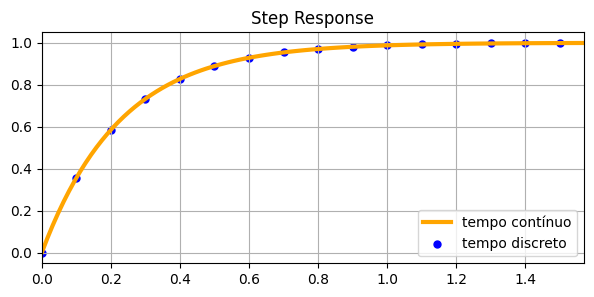

In [185]:
plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)

plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time, response = ctl.step_response(C_z)
plt.scatter(time, response, color='blue', s=25, label='tempo discreto')

plt.title('Step Response')
plt.legend()
plt.grid()

- As funções abaixo serão usadas para discretizar a função de transferência no domínio $z$ para uma função a partir dos seus estados anteriores

In [186]:
def getDigitalFraction(C_z):
    num, den = ctl.tfdata(C_z)
    num = np.squeeze(num)
    den = np.squeeze(den)

    num = num/den[0]
    den = den/den[0]

    if type(num) == np.float64:
        num = np.array([num])

    return list(num), list(den)


num, den = getDigitalFraction(C_z)
num, den

([0.3558495560245919], [1.0, -0.6441504439754081])

In [187]:
def getDigitalFunction(C_z):
    num, den = getDigitalFraction(C_z)
    out = ''
    
    for i in range(0, len(num)): 
        out += f'X_n{i}*({num[i]:.6f}) + '

    for i in range(1, len(den)): 
        out += f'Y_n{i}*({-1*den[i]:.6f}) + '
    
    return out.replace('X_n0', 'X_n')[:-3]


out = getDigitalFunction(C_z)
print(out + ';')

X_n*(0.355850) + Y_n1*(0.644150);


- Criando a função no "estilo" C++ para confirmar se a máquina consegue implementar

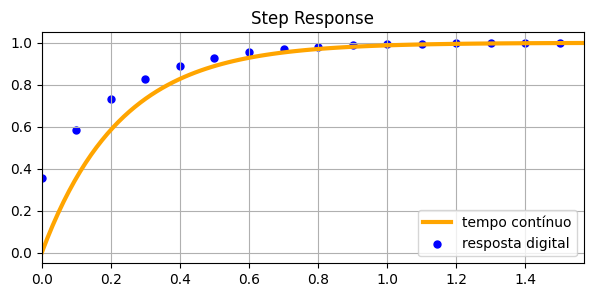

In [188]:
Y_n1 = X_n1 = 0

def compute(X_n):
    global Y_n1, X_n1
    Y_n = eval(out)
    X_n1 = X_n
    Y_n1 = Y_n
    return Y_n


plt.figure(figsize=(7, 3))
time, response = ctl.step_response(C)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')
plt.xlim(min(time), max(time))

time     = np.arange(0, 20, T)
response = [compute(1) for i in time] 
plt.scatter(time, response, color='blue', s=25, label='resposta digital')

plt.title('Step Response')
plt.grid()
plt.legend()
plt.show()

- Comparando o filtro digital com o filtro perfeito

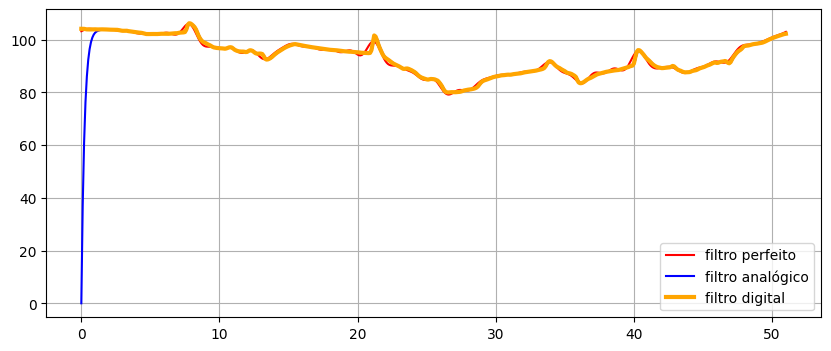

In [189]:
xTest, yTest  = df.time.values, df.pressure.values
timeArray     = np.linspace(xTest[0], xTest[-1], len(xTest))
time, reponse = ctl.forced_response(C, T=timeArray, U=yTest)
for i in range(100): compute(yTest[0]) # RECALIBRANDO

plt.figure(figsize=(10, 4))
plt.plot(xData, yData, label='filtro perfeito', color='red')
plt.plot(time, reponse, label='filtro analógico', color='blue')
plt.plot(xTest, [compute(y) for y in yTest], label='filtro digital', color='orange', linewidth=3)
plt.legend()
plt.grid()

# COMPARAÇÃO GERAL DOS DADOS

,time,pressure
0,0.0,104.1020
1,0.1,104.1208
2,0.2,104.0262
3,0.3,103.7383
4,0.4,103.7310


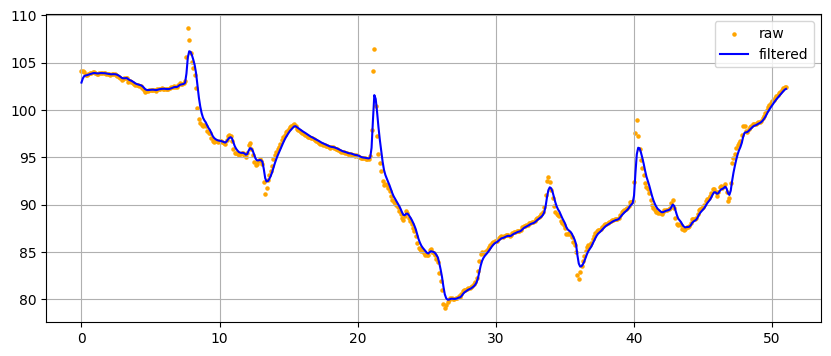

In [190]:
df = pd.read_csv(path) 

df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', T)
display(df.head())

plt.figure(figsize=(10, 4))
plt.scatter(df.time, df.pressure, color='orange', s=5, label='raw')
plt.plot(df.time, [compute(y) for y in df.pressure], color='blue', label='filtered')

plt.grid()
plt.legend()